Processing C:\Users\VINUTHA R\Desktop\Data\0001_001_S6_00100_00060_3200_L\GT_SRGB_010.PNG
PSNR: 27.76 dB
SSIM: 0.0060


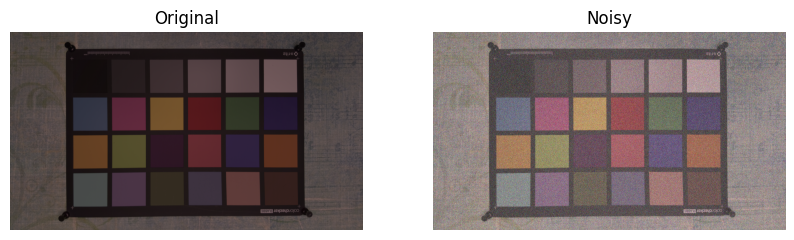

Processing C:\Users\VINUTHA R\Desktop\Data\0002_001_S6_00100_00020_3200_N\GT_SRGB_010.PNG
PSNR: 28.16 dB
SSIM: 0.0094


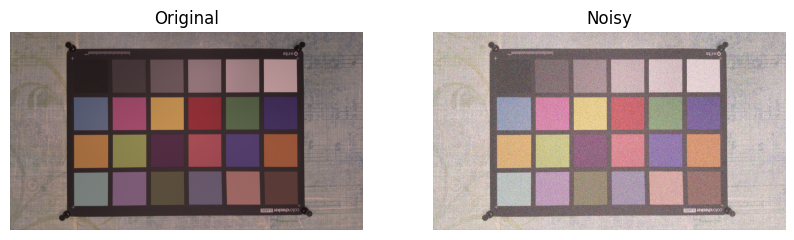

Processing C:\Users\VINUTHA R\Desktop\Data\0003_001_S6_00100_00060_3200_H\GT_SRGB_010.PNG
PSNR: 28.00 dB
SSIM: 0.0236


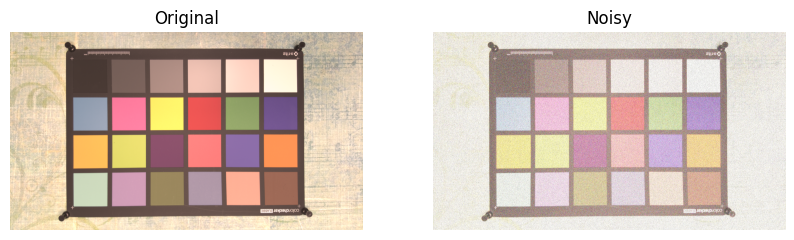

Processing C:\Users\VINUTHA R\Desktop\Data\0004_001_S6_00100_00060_4400_L\GT_SRGB_010.PNG
PSNR: 27.74 dB
SSIM: 0.0071


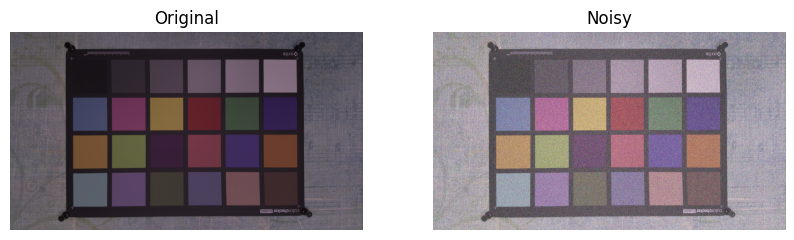

Processing C:\Users\VINUTHA R\Desktop\Data\0005_001_S6_00100_00060_4400_N\GT_SRGB_010.PNG
PSNR: 27.75 dB
SSIM: 0.0164


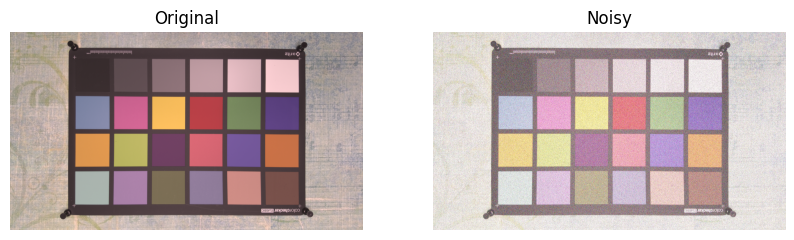

In [1]:
import os
import numpy as np
from scipy.stats import poisson
import cv2
import matplotlib.pyplot as plt

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(original, noisy):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(original, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(noisy, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(original ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(noisy ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(original * noisy, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_value = ssim_map.mean()

    return ssim_value

def add_poisson_gaussian_noise(image, sigma_read, total_gain, noise_scale=1.0, poisson_scale=1.0):
    image = np.clip(image.astype(np.float32) / 255.0, 0.0, 1.0)
    channels = np.split(image, 3, axis=2)

    noisy_channels = []
    for channel in channels:
        photon_counts = channel * total_gain
        shot_noise = poisson.rvs(photon_counts) / total_gain
        shot_noise *= poisson_scale
        read_noise = np.random.normal(loc=0.0, scale=sigma_read, size=channel.shape)
        noisy_channel = shot_noise + read_noise * noise_scale
        noisy_channels.append(noisy_channel)

    noisy_image = np.clip(np.dstack(noisy_channels), 0.0, 1.0)
    return (noisy_image * 255).astype(np.uint8)

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    num_salt = np.ceil(salt_prob * image.size)
    num_pepper = np.ceil(pepper_prob * image.size)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image

def add_combined_noise(image, sigma_read, total_gain, noise_scale, poisson_scale, salt_prob, pepper_prob):
    noisy_image = add_poisson_gaussian_noise(image, sigma_read, total_gain, noise_scale, poisson_scale)
    noisy_image = add_salt_and_pepper_noise(noisy_image, salt_prob, pepper_prob)
    return noisy_image

# Set parameters
sigma_read = 0.1
total_gain = 500.0
noise_scale = 5.0
poisson_scale = 2.0
salt_prob = 0.02
pepper_prob = 0.02

dataset_folder = "C:\\Users\\VINUTHA R\\Desktop\\Data"
plot_count = 0
max_plots = 5

for root, _, files in os.walk(dataset_folder):
    for file in files:
        if file.startswith('GT_SRGB_010') and file.endswith('.PNG'):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

            noisy_image = add_combined_noise(image, sigma_read, total_gain, noise_scale, poisson_scale, salt_prob, pepper_prob)

            psnr_value = psnr(image, noisy_image)
            ssim_value = ssim(image, noisy_image)

            print(f"Processing {image_path}")
            print(f"PSNR: {psnr_value:.2f} dB")
            print(f"SSIM: {ssim_value:.4f}")

            if plot_count < max_plots:
              
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[0].set_title('Original')
                axes[0].axis('off')
                axes[1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
                axes[1].set_title('Noisy')
                axes[1].axis('off')

                plt.show()
                plot_count += 1

            if plot_count >= max_plots:
                break
    if plot_count >= max_plots:
        break
    

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, AveragePooling2D, Add, Activation, Reshape, GlobalAveragePooling2D, Multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_images_from_directory(directory, target_size=(256, 256), keyword='noisy_srgb'):
    images = []
    print(f"Loading images from directory: {directory} with keyword: {keyword}")
    try:
        filenames = os.listdir(directory)
        print(f"Found {len(filenames)} files in the directory.")
        for filename in filenames:
            if keyword in filename.lower() and filename.lower().endswith((".jpg", ".png")):
                print(f"Processing file: {filename}")
                img_path = os.path.join(directory, filename)
                img = Image.open(img_path).resize(target_size)
                img_array = np.array(img)
                images.append(img_array)
            else:
                print(f"Skipping file (unsupported format or does not contain keyword): {filename}")
    except Exception as e:
        print(f"Error reading directory: {e}")
    return np.array(images)

def process_dataset(main_directory, keyword='noisy_srgb', target_size=(256, 256)):
    all_images = []
    subfolders = [f.path for f in os.scandir(main_directory) if f.is_dir()]
    print(f"Found {len(subfolders)} subfolders in the directory: {main_directory}")
    for subfolder in subfolders:
        print(f"Processing subfolder: {subfolder}")
        images = load_images_from_directory(subfolder, target_size, keyword)
        print(f"Loaded {len(images)} images from subfolder: {subfolder}")
        all_images.extend(images)
    return np.array(all_images)

main_directory = r"C:\Users\VINUTHA R\Desktop\Data"  

all_images = process_dataset(main_directory, keyword='noisy_srgb')

X_train_patches, X_test_patches = train_test_split(all_images, test_size=0.2, random_state=42)
y_train_patches = X_train_patches  
y_test_patches = X_test_patches


print(f"Train images shape: {X_train_patches.shape}")
print(f"Test images shape: {X_test_patches.shape}")

X_train_patches = X_train_patches / 255.0
y_train_patches = y_train_patches / 255.0
X_test_patches = X_test_patches / 255.0
y_test_patches = y_test_patches / 255.0

class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, i):
        batch_indexes = self.indexes[i * self.batch_size:(i + 1) * self.batch_size]
        batch_x = self.X[batch_indexes]
        batch_y = self.y[batch_indexes]
        return batch_x, batch_y

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

batch_size = 2  
train_dataloader = Dataloder(X_train_patches, y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches, y_test_patches, batch_size, shuffle=False)

def show_batch(dataloader, batch_num=0):
    batch_x, batch_y = dataloader[batch_num]
    print(f"Batch {batch_num} - batch_x shape: {batch_x.shape}, batch_y shape: {batch_y.shape}")
    if len(batch_x) == 0:
        print("Empty batch!")
        return
    fig, axes = plt.subplots(1, len(batch_x), figsize=(15, 15))
    for img, ax in zip(batch_x, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.show()

show_batch(train_dataloader, batch_num=0)


tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(3, (3, 3), activation="sigmoid", kernel_initializer='he_normal', padding="same")(x)


autoencoder = Model(input, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())


autoencoder.fit(train_dataloader, epochs=10)


In [4]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
x = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)

x = concatenate([x, input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(x)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv1)

pool1 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv4)

pool2 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(conv11)
add1 = Add()([upsample1, conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal', padding="same")(conv14)
add1 = Add()([upsample2, conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(conv15)

out = Conv2D(3, (1, 1), kernel_initializer='he_normal', padding="same")(conv16)
out = Add()([out, input])

CBDNet = Model(input, out)
CBDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.MeanSquaredError())

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7)
CBDNet.fit(train_dataloader, epochs=10, callbacks=[reduce_lr])

history = CBDNet.fit(train_dataloader, validation_data=test_dataloader, epochs=10, callbacks=[reduce_lr])


class EAM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv2D(64, (3, 3), dilation_rate=1, padding='same', activation='relu')
        self.conv2 = Conv2D(64, (3, 3), dilation_rate=2, padding='same', activation='relu')
        self.conv3 = Conv2D(64, (3, 3), dilation_rate=3, padding='same', activation='relu')


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - loss: 7001.3901
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - loss: 9.3152
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - loss: 4.1568
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - loss: 2.9885
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - loss: 1.9178
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2262s 36s/step - loss: 1.6446
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - loss: 1.6823
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - loss: 0.9136
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - loss: 0.9032
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - loss: 0.8147


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


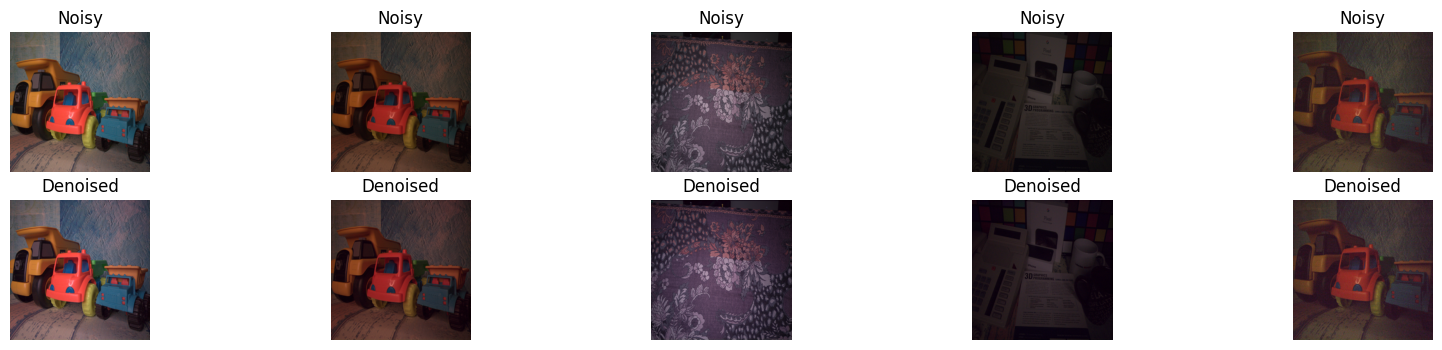

In [8]:
def display_images(original, denoised, num_images=5):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].astype(np.uint8))
        plt.title("Noisy")
        plt.axis("off")

        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(denoised[i].astype(np.uint8))
        plt.title("Denoised")
        plt.axis("off")

    plt.show()

test_images_normalized = X_test_patches / 255.0

denoised_images = CBDNet.predict(test_images_normalized)

denoised_images = denoised_images * 255.0
denoised_images = np.clip(denoised_images, 0, 255).astype(np.uint8)


display_images(X_test_patches, denoised_images)